In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Multiply, Input, Concatenate


In [4]:
train_path = "../Computer Vision Masterclass/Datasets/cat_dog_2/training_set"
test_path = "../Computer Vision Masterclass/Datasets/cat_dog_2/test_set"

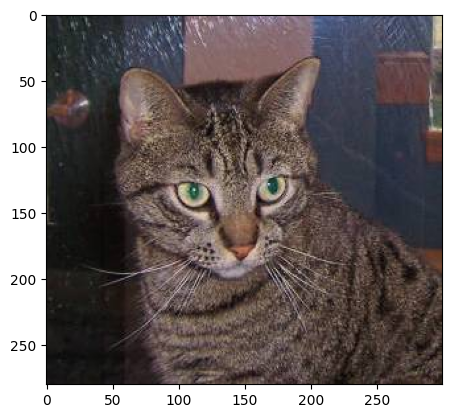

In [5]:
img = cv2.imread(train_path + "/cat/cat.1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
plt.imshow(img)

In [6]:
# ImageDataGenerator to apply data augmentation, randomly translating, rotating, resizing, etc.
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_datagen.fill_mode='constant'
train_datagen.horizontal_flip=True
train_datagen.zoom_range=[0.8, 1.2]
train_datagen.rotation_range=20
train_datagen.shear_range=10
train_datagen.brightness_range = [0.75, 1.5]



#making image as 227X227 for input of alexnet
# train = train_datagen.flow_from_directory(train_path, target_size=(227,227), class_mode='categorical')
train = train_datagen.flow_from_directory(train_path, target_size=(64, 64), shuffle=True, class_mode='categorical')


Found 4000 images belonging to 2 classes.


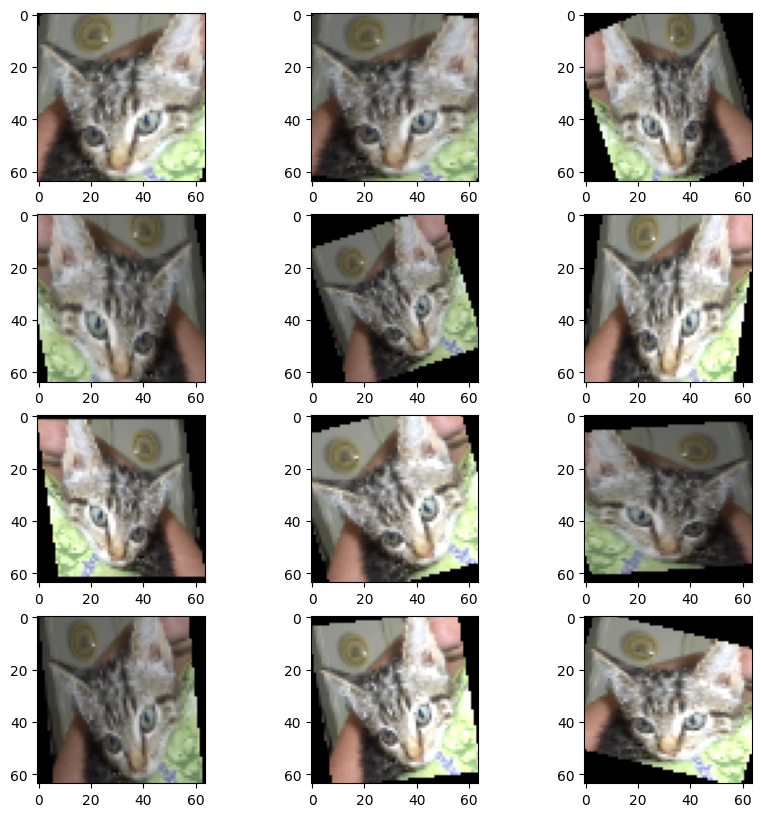

In [7]:
fig , axs = plt.subplots(4,3 ,figsize = (10,10))

axs[0][0].imshow(train[1][0][0])
axs[0][1].imshow(train[1][0][0])
axs[0][2].imshow(train[1][0][0])
axs[1][0].imshow(train[1][0][0])
axs[1][1].imshow(train[1][0][0])
axs[1][2].imshow(train[1][0][0])
axs[2][0].imshow(train[1][0][0])
axs[2][1].imshow(train[1][0][0])
axs[2][2].imshow(train[1][0][0])
axs[3][0].imshow(train[1][0][0])
axs[3][1].imshow(train[1][0][0])
axs[3][2].imshow(train[1][0][0])

In [8]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test = test_datagen.flow_from_directory(test_path, target_size=(64,64), shuffle=False, class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def dense_block(X, num_layers, growth_rate):
    for i in range(num_layers):
        # Bottleneck layer
        X1 = BatchNormalization()(X)
        X1 = ReLU()(X1)
        X1 = Conv2D(4 * growth_rate, (1, 1), padding='same')(X1)
        
        # 3x3 Convolution layer
        X1 = BatchNormalization()(X1)
        X1 = ReLU()(X1)
        X1 = Conv2D(growth_rate, (3, 3), padding='same')(X1)
        
        # Concatenate
        X = Concatenate()([X, X1])
    return X

def transition_layer(X, reduction):
    num_filters = int(X.shape[-1] * reduction)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv2D(num_filters, (1, 1), padding='same')(X)
    X = tf.keras.layers.AvgPool2D((2, 2), strides=(2, 2))(X)
    return X

def DenseNet(input_shape=(224, 224, 3), num_classes=10, num_dense_blocks=3, num_layers_per_block=4, growth_rate=12, reduction=0.5):
    X_input = Input(shape=input_shape)
    
    # Initial Convolution and Pooling
    X = Conv2D(2 * growth_rate, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same')(X)
    
    # Dense Blocks with Transition Layers
    for i in range(num_dense_blocks):
        X = dense_block(X, num_layers_per_block, growth_rate)
        if i != num_dense_blocks - 1:  # Don't apply transition layer after the last dense block
            X = transition_layer(X, reduction)
    
    X = Dropout(0.2)(X)

    # Global Average Pooling and Output Layer
    X = GlobalAveragePooling2D()(X)
    X = Dense(num_classes, activation='softmax')(X)
    
    # Create Model
    model = Model(inputs=X_input, outputs=X, name='DenseNet')
    
    return model

# Initialize the model
network = DenseNet(input_shape=(64, 64, 3), num_classes=2)

# Print model summary
network.summary()


Model: "DenseNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │      3,552 │ input_layer_1[0]… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         96 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ re_lu_27[0][0]    │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         96 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │      1,200 │ re_lu_28[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        192 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 16, 16,    │      5,196 │ re_lu_29[0][0]    │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│ (Concatenate)       │ 36)               │            │ conv2d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        144 │ concatenate_12[0… │
│ (BatchNormalizatio… │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 16, 16,    │      1,776 │ re_lu_30[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        192 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 108,332 (423.17 KB)

 Trainable params: 105,572 (412.39 KB)

 Non-trainable params: 2,760 (10.78 KB)

In [13]:
# Define the learning rate you want to use
learning_rate = 0.0001  # Example learning rate

# Instantiate the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile your neural network model with the customized optimizer
network.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = network.fit(train, epochs=20)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5483 - loss: 0.6898
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6240 - loss: 0.6517
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6565 - loss: 0.6245
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6504 - loss: 0.6305
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6708 - loss: 0.6044
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6747 - loss: 0.6006
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6666 - loss: 0.5996
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6870 - loss: 0.5886
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6777 - loss: 0.5982
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7163 - loss: 0.5493
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7192 - loss: 0.5575
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━

In [15]:
predictions = network.predict(test)
predictions

d:\D-Program Files\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


array([[0.97653145, 0.02346864],
       [0.64001465, 0.35998535],
       [0.80809265, 0.19190738],
       ...,
       [0.14485578, 0.8551442 ],
       [0.41826466, 0.5817354 ],
       [0.5125127 , 0.4874873 ]], dtype=float32)

In [16]:
# predicted values
predictions = np.argmax(predictions, axis=1)
predictions 

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

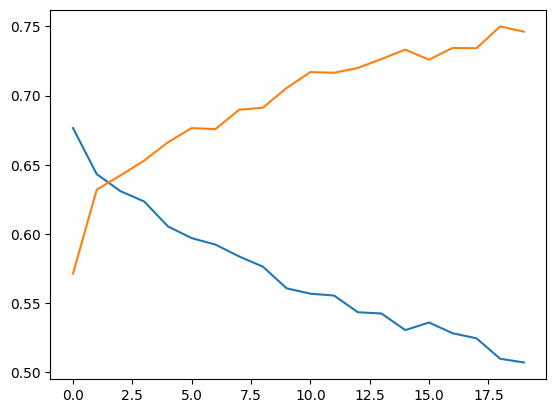

In [17]:
plt.plot(history.history['loss'] )
plt.plot(history.history['accuracy'] )

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(test.classes, predictions)

0.67